# Welcome!

#### In this workbook we'll look at how acoustic levitation works. To start with a small intro to matricies might be useful as it will come up a lot.  
(You might already know this but I know I was very confused by all this when I first encountered it)

# Matricies

#### A matrix is a table of numbers which we can interact with as a single unit. We can talk about the shape of a matrix as (N,M) or NxM for N rows and M columns. First lets import Pytorch which gives us the ability to make matricies (they call them tensors as they can be more than 2D)

In [1]:
import torch, math
import matplotlib.pyplot as plt


In [2]:
N = 2
M = 2

matrix = torch.randint(5, (N,M)) #Create a matrix of shape NxM
print(matrix) 
print(matrix.shape) 

tensor([[2, 4],
        [0, 2]])
torch.Size([2, 2])


#### Matricies can be added, subtracted and multiplied element-wise in a way you would expect

In [3]:
N = 2
M = 2

matrix_1 = torch.randint(5, (N,M)) #Create a matrix of shape NxM
matrix_2 = torch.randint(5, (N,M)) #Create a matrix of shape NxM
 
matrix_result = matrix_1 + matrix_2 # Try changing the + to -, *, /

print(matrix_1, matrix_2, matrix_result, sep='\n')


tensor([[0, 1],
        [4, 0]])
tensor([[1, 2],
        [0, 4]])
tensor([[1, 3],
        [4, 4]])


#### Weirdly though, when we talk about matrix multiplication its normally not what you would expect - we take each row of the first matrix and then multiply it element-wise with each column of the second matrix, then sum these results which becomes the resulting matrix's elements (like the dot product for vectors).

In [4]:
N = 2
M = 2

matrix_1 = torch.randint(5, (N,M)) #Create a matrix of shape NxM
matrix_2 = torch.randint(5, (N,M)) #Create a matrix of shape NxM
 
matrix_result = matrix_1 @ matrix_2 # @ is matrix multiplication

print(matrix_1, matrix_2, matrix_result, sep='\n')
print("For the top left element of the result",matrix_1[0,0].item(),"*",matrix_2[0,0].item(), "+" ,matrix_1[0,1].item(),"*",matrix_2[1,0].item(),"=", matrix_result[0,0].item())

tensor([[4, 2],
        [1, 0]])
tensor([[0, 3],
        [0, 4]])
tensor([[ 0, 20],
        [ 0,  3]])
For the top left element of the result 4 * 0 + 2 * 0 = 0


#### We can use these to compute lots of the same calculations at the same time. For example, if the matrix represents (x,y) positions we can scale by some factor

tensor([[3, 2],
        [2, 3],
        [3, 3],
        [2, 2]])
tensor([[9, 6],
        [6, 9],
        [9, 9],
        [6, 6]])


(-0.45, 9.45, -0.45, 9.45)

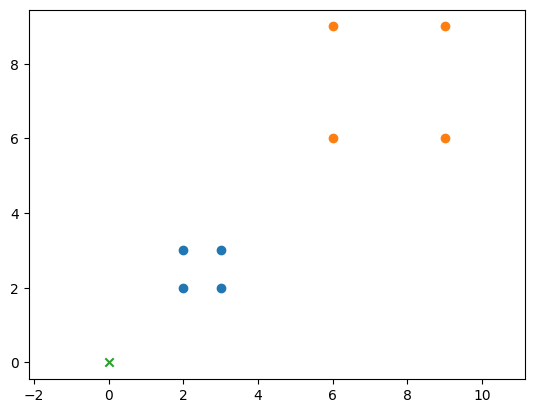

In [5]:
N = 4
positions = torch.randint(1,4,(N,2))
print(positions)

scale = 3

scaled_positions = positions * scale
print(scaled_positions)

plt.scatter(positions[:,0], positions[:,1])
plt.scatter(scaled_positions[:,0], scaled_positions[:,1])
plt.scatter([0,],[0,],marker='x')
plt.axis("equal")

#### Or we can rotate them all by some angle with a rotation matrix (dont worry why it has this form). This matrix $R$ will rotate the points around (0,0) by some angle $\theta$

$$
R = \begin{bmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix}
$$

#### Also see how we can use normal python list indexing to get parts of matricies. We still use square brackets and seperate the different dimentions with commas. A colon means to take all of that dimension


(-0.2, 4.2, -4.4, 4.4)

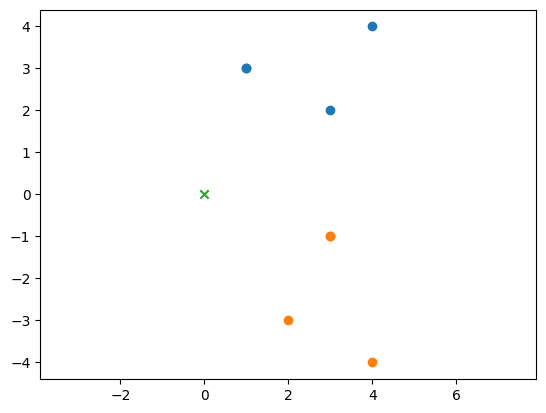

In [6]:
N = 4
positions = torch.randint(1,5,(N,2)).to(torch.float) #2D positions

angle = torch.pi / 2 #angle in rads

rotation = torch.tensor([
    [math.cos(angle), -math.sin(angle)],
    [math.sin(angle), math.cos(angle)]
])


rot_positions = positions @ rotation 

plt.scatter(positions[:,0], positions[:,1])
plt.scatter(rot_positions[:,0], rot_positions[:,1])
plt.scatter([0,],[0,],marker='x')
plt.axis("equal")


#### PyTorch nicely includes a lot of functions for us to do things like adding up all the elements of a tensor (`torch.sum`), using all the elements as an exponent of $e$ (`torch.exp` - this we will use a lot!) and reshaping tensors while keeping the same data (`torch.reshape`) - we will use some of these in future

# Acoustics

#### Now lets look at the actual acoustics - lets start by just importing some modules

In [7]:
from acoustools.Utilities import create_points, create_board, propagate_abs, device, TRANSDUCERS, add_lev_sig
from acoustools.Visualiser import Visualise, ABC, Visualise_single
from acoustools.Constants import k
from acoustools.Solvers import wgs



#### Firstly lets look at a single transducer. A transducer is made up of a vibrating membrane which produces sound waves. These waves have an amplitude (the 'size' of oscillation) and a phase (how 'delayed' a wave is). These can be combined into a single number for the wave $Ae^{i\varphi}$ for the amplitude $A$ and phase $\varphi$ (technically this changes across time too but we can ignore that here as its so fast). Here $i = \sqrt{-1}$ but for python this number is denoted by `1j`

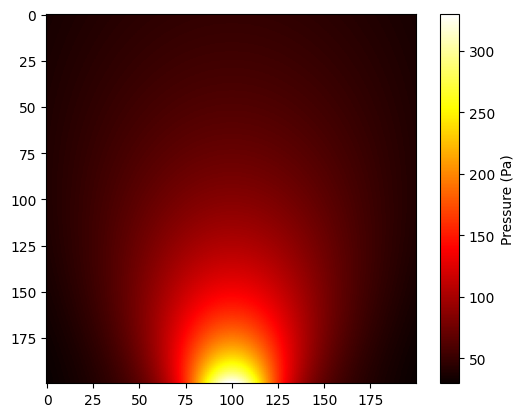

In [8]:
single_transducer = create_board(2,z=-0.04).to(device)

amplitude = 1 #Any number between 0 and 1
phase = 0 #Any number between 0 and 2pi
x_st = amplitude * torch.exp(torch.ones(1,1) * 1j * phase)

A,B,C = ABC(0.03)
Visualise(A,B,C,x_st,colour_functions=[propagate_abs],colour_function_args=[{'board':single_transducer}])

#### This is the result of a single transducer - a slightly oval shaped cone of pressure that diminishes over time. However, this isn't very helpful as theres no stable levitation points. A stable point needs little pressure at that point (so a particle doesn't get pushed out) and has high pressure around it (so a particle is held in place). This can be achieved with a standing wave

#### A standing wave can be created from two waves travelling in opposite directions. Press the play next to $t$ in the graph below (run the next cell if it hasn't appeared), two waves (blue and green) travel in opposite directions and the resulting wave (orange) stays in place. Note that there are points (nodes) where the amplitude (height) of the wave is always zero while the amplitude surrounding it is not zero

#### Also note when the reuslting (orange) wave has maximum amplitude - when the blue and green waves overlap perfectly (in phase) and the orange is at its smallest when they are half a cycle apart (out of phase)

In [9]:
from IPython.display import IFrame
IFrame("https://www.desmos.com/calculator/sxclct7qir", 1000, 500)

#### We can achieve this by using two transduers facing one another

#### Set `x_tt` to the correct activation ($Ae^{i\varphi}$) for the two transducers (Hint: compare how we did it for one - what needs to change for two transducers?)

In [10]:
t1 = create_board(2,z=-0.04)
t2 = create_board(2,z=0.04)

two_transducers = torch.cat((t1,t2),axis=0).to(device)

point = create_points(1,1,0,0,0)

amplitude = 1
phase = 0
x_tt = amplitude * torch.exp(torch.ones(2,1) * 1j * phase)

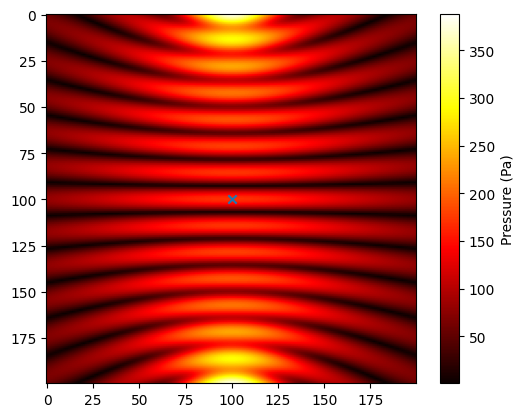

In [11]:
A,B,C = ABC(0.03)
Visualise(A,B,C,x_tt,points=point,colour_functions=[propagate_abs],colour_function_args=[{'board':two_transducers}])

#### Here, the point in the middle of the two transducers is a anti-node of the standing wave - a point of high pressure (high amplitude) because the waves have travelled the same distance and so have the same phase and therefore constructively interfere (add up)

#### To make a levitation point we want them to destructively interfere - to cancel out and create zero pressure. This can be done by shifting the top wave so that they arrive at that point perfectly out of phase and so the two waves cancel out. This means the top wave needs to be shifted by half of its full cycle or $\pi$ radians

#### We can extract the phase and amplitude from `x_tt` as follows. Add $\pi$ to only the second transducer's phase

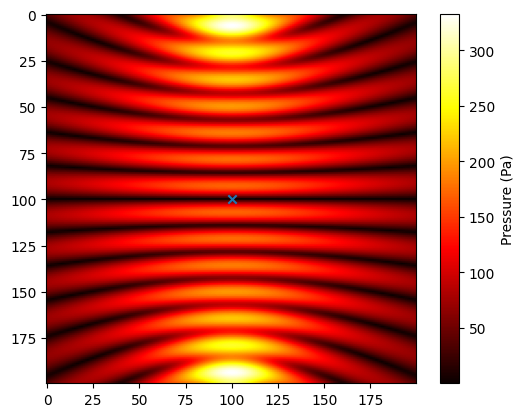

In [12]:
point = create_points(1,1,0,0,0)

phase = torch.angle(x_tt)
amplitude = torch.abs(x_tt)
phase[1,:] += torch.pi


x_tt_trap = amplitude * torch.exp(phase * 1j)

A,B,C = ABC(0.03)
Visualise(A,B,C,x_tt_trap,points=point,colour_functions=[propagate_abs],colour_function_args=[{'board':two_transducers}])

#### Now the waves cancel in the middle and we could hold a particle there. The pressure here is quite small though - two transducers can't provide that much power. In order to improve the power of the device we could have many of these pairs. In order to maintain the focus in this point the distance to all the transducers should be the same (as the distance the wave has travelled determines its phase). This means that the transducers should be arranged in a sphere.

#### To generate positions in a sphere we can use the following equations
$$
x = r  sin(t) cos(nt) \\
y = r  sin(t)  sin(nt) \\ 
z = r  cos(t) 
$$
#### So if we have 256 different values for t we can generate 256 different positions all in a sphere 
(this technically wont make pairs like we mentioned but its close enough for this - they'll all be in a sphere so the distances all are the same)

In [13]:
def sphere(n, r):
    points = []
    for t in range(n):
        x = r * math.sin(t) * math.cos(n*t)
        y = r * math.sin(t) * math.sin(n*t)
        z = r * math.cos(t)
        points.append([x,y,z])

    points = torch.Tensor(points)
    return points

point = create_points(1,1,0,0,0)


spherical_board = sphere(512, 0.12)
x_sphere = torch.exp(1j*torch.zeros((512,1)))


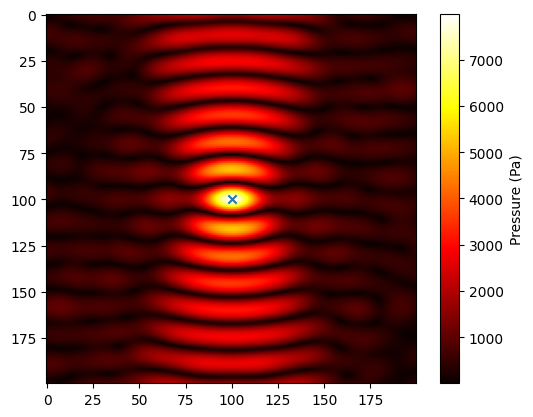

In [14]:
A,B,C = ABC(0.03)
Visualise(A,B,C,x_sphere,points=point,colour_functions=[propagate_abs],colour_function_args=[{'board':spherical_board}])

#### This makes a focal point with much higher pressure! However, these levitators are harder to make as the transducers need to be arranged in the sphere and they also reduce the volume you can use. We normally use transducers arranged into flat grids. When using these grids though we need to be more careful about the signals used. Using a constant signal like we have done before doesnt focus sound properly because all the waves now travel different distances. 

In [15]:
board = TRANSDUCERS #Flat arrays
point = create_points(1,1,0,0,0)
x_board = torch.exp(1j*(torch.zeros((512,1))))

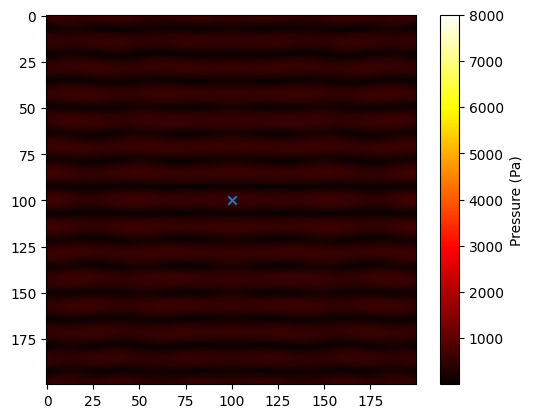

In [16]:
A,B,C = ABC(0.03)
Visualise(A,B,C,x_board,points=point,colour_functions=[propagate_abs],colour_function_args=[{'board':board}],vmax=8000)

#### In order to focus sound at a point we need to adjust the waves so the waves arrive at the same phase - making it seem as if the transducers are the same distance away by delaying some of the waves. In order to delay the waves we can change the phase - this has the same effect as delay as the waves will reach the focus point with a different phase.

#### This phase delay needs to make all the waves arrive with the same phase, so we need to know the distance from a transducer to a point. The phase of the wave after traveling some distance is equal to the number of wavelengths traveled times $2 \pi$. Therefore to make all the waves phase equal we can just subtract this value from each transducer making all transducers have a phase of zero when they meet. 

#### This 'number of wavelengths' can be expressed as $2\pi * d / \lambda = kd$ where $d$ is the distance and $k$ is the wavenumber $k=2\pi / \lambda$ for the wavelength $\lambda$. You've imported the wavenumber as the variable `k` above so can just use `k`

#### The distance from a transducer to a point can be computed using pythagoras with the distance in each axis

In [17]:
def compute_distance(board, point):
    distance = torch.sqrt(torch.sum((board.unsqueeze(0).mT - point.expand(1,3,512))**2,axis=1))
    return distance.T

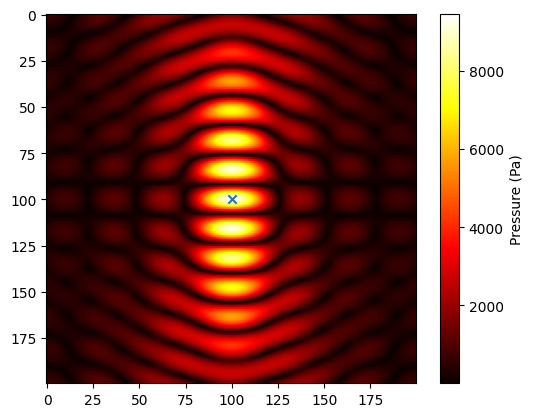

In [18]:
point = create_points(1,1,0,0,0)


distance = compute_distance(board, point)
x = torch.exp(1j*(torch.zeros((512,1)) - distance*k))

A,B,C = ABC(0.03)
Visualise(A,B,C,x,points=point,colour_functions=[propagate_abs],colour_function_args=[{'board':board}])

#### This also works at points other than the centre of the array as the distance is taken into account for the focusing!

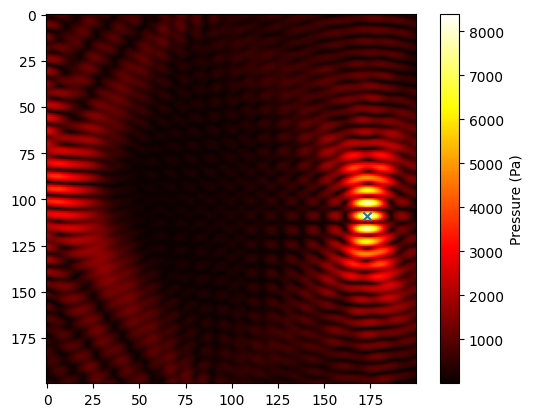

In [19]:
point = create_points(1,1, y=0)

distance = compute_distance(board, point)
x = torch.exp(1j*(torch.zeros((512,1)) - distance*k))

A,B,C = ABC(0.07)
Visualise(A,B,C,x,points=point,colour_functions=[propagate_abs],colour_function_args=[{'board':board}])

#### However, this only works for one point at a time, to focus at other points we need more complex methods. WGS is an algorithm that will focus sound across multiple points. This is more complex and doesnt really matter how it works

#### Note that the more points you have the lower the pressure at each point becomes. Try different values for the number of points `N` and compare the maximum pressure on the scale on the right

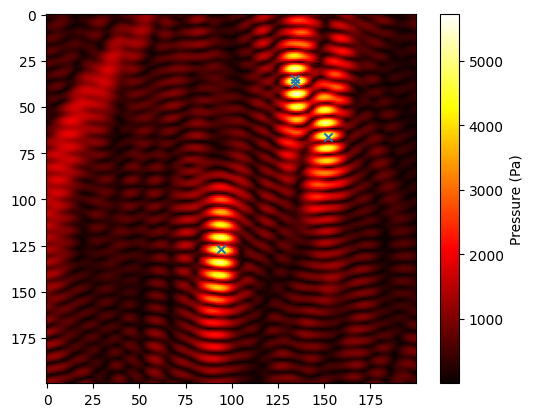

In [20]:
N = 4
points = create_points(N,1,y=0)

x_wgs = wgs(points, board=board)

A,B,C = ABC(0.07)
Visualise(A,B,C,x_wgs,points=points,colour_functions=[propagate_abs],colour_function_args=[{'board':board}])

#### As we discussed above, these points wont trap particles at the right positions. In the same way we added $\pi$ radians to one transducer before, we can do the same thing now. By adding $\pi$ to one of the boards (half the transducers) the waves will cancel out at those points instead of building up.

#### Add $\pi$ to the phase of only the top board (the last 256 transducers)

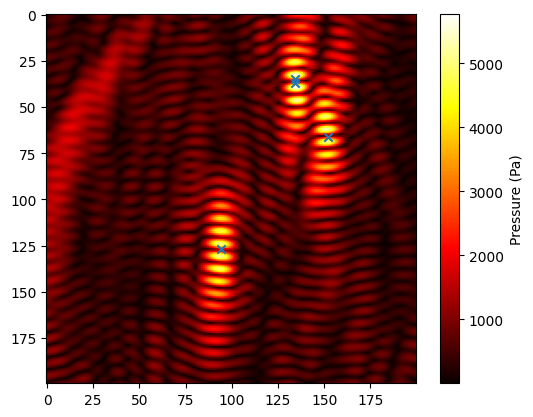

In [21]:
phase = torch.angle(x_wgs)
amp = torch.abs(x_wgs)

phase[:,256:] += torch.pi

x_trap_wgs_manual = amp * torch.exp(1j * phase)

A,B,C = ABC(0.07)
Visualise(A,B,C,x_trap_wgs_manual,points=points,colour_functions=[propagate_abs],colour_function_args=[{'board':board}])

#### This can be simplified like this

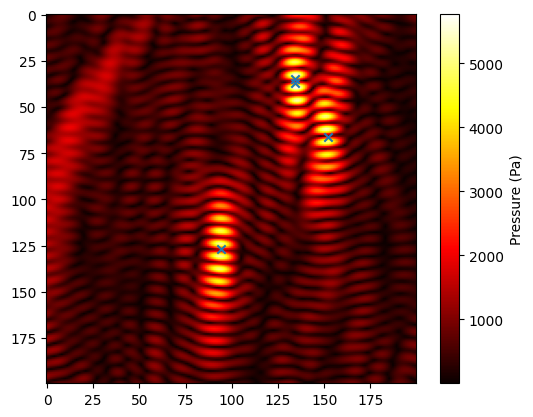

In [22]:
x_wgs_trap = add_lev_sig(x_wgs)

A,B,C = ABC(0.07)
Visualise(A,B,C,x_wgs_trap,points=points,colour_functions=[propagate_abs],colour_function_args=[{'board':board}])

# Circle

#### Now to make something a bit more tangible - lets make a circular path that we can make a particle follow in midair!

#### Firstly, we want to define the path. Similarly to how we made the sphere earlier the parametric equations for a circle are

$$
    x = r sin(\theta) \\
    y = r cos(\theta)

$$

#### So if we can vary $\theta$ through the whole $2 \pi$ range we can get all the points to draw a circle

In [23]:
positions = []
NP = 200 #Number of points
r = 0.03 #Radius
for t in range(NP+1):
    x = r * math.sin((2 * math.pi / NP) * t)
    y = r * math.cos((2 * math.pi / NP) * t)
    positions.append((x,y))


#### Lets plot these positions to check they make a circle

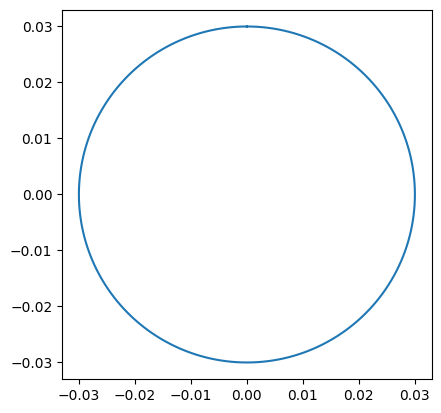

In [24]:
xs = [i[0] for i in positions]
ys = [i[1] for i in positions]
plt.plot(xs, ys)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')



#### Using these positions we can the make a focal point using WGS as we have done before

In [25]:
xs = []
for x,y in positions:
    p = create_points(1,1,x,y,0)
    x = wgs(p)
    xs.append(x)


#### Try sending this to the levitator - put your hand in the centre and you should feel a circular pattern on your hand 

In [26]:
#Levitate

#### Then we can make this into a trap by adding $\pi$ to the top board

In [27]:
x_traps = []
for x in xs:
    x_traps.append(add_lev_sig(x))


#### Now send this to the levitator - put a bead at the start of the path (if you wave your hand through the area you should feel the location) and press enter to move the bead

In [28]:
#Levitate


# Something else!

#### Now try and make something different - think about what you want to make!

#### You could pick random numbers to try and draw on your hand and see how many you get right - look at `acoustools.paths.get_numeral`
#### You could try levitate multiple particles at once - maybe draw a smiley face or something else - look at changing `N` for `compute_points`
#### But choose something you want to do and play around! Good luck!